# **비즈니스 문제 정의**
- 패션 이커머스는 반복 구매가 핵심
- 고객 이탈은 매출 감소로 직결
- 이탈 위험 고객을 조기 탐지해야 함

## **Data Preparation**

In [ ]:
import pandas as pd
# 거래 데이터 불러오기
transactions=pd.read_parquet("./data/transactions_train.parquet")

In [ ]:
transactions.shape

(31788324, 5)

In [ ]:
# 날짜 타입 변환 ( 날짜 계산하려면 datetime 타입 )
transactions['t_dat']=pd.to_datetime(transactions['t_dat'])

In [ ]:
# 데이터 중에서 가장 최근 구매일
latest_date=transactions['t_dat'].max()
latest_date

Timestamp('2020-09-22 00:00:00')

## **RFM**
### 고객 행동을 요약하는 기본적인 프레임워크 지정
- Recency : 마지막 구매 이후 경과일
- Frequency : 구매 횟수
- Monetary : 총 구매 금액

## **RFM Feature Engineering**

In [ ]:
# 고객별 요약 ( RFM 만들기)
rfm=transactions.groupby('customer_id').agg({
    't_dat': 'max',
    'price': ['count','sum']
})

In [ ]:
# RFM 컬럼 정리
rfm.columns=['latest_purchase','frequency','monetary']
rfm=rfm.reset_index()

In [ ]:
# Recency 계산 : 마지막 구매 후 경과일
rfm['recency']=(latest_date-rfm['latest_purchase']).dt.days

## **Churn Definition**

In [ ]:
# churn 정의 (90일 기준) : 이탈 여부
rfm['churn']=(rfm['recency']>90).astype(int)

In [ ]:
rfm.head()

,customer_id,latest_purchase,frequency,monetary,recency,churn
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,21,0.648983,17,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,86,2.601932,76,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,18,0.704780,7,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,2,0.060983,471,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,13,0.469695,41,0


## **Exploratory Data Analysis**

"이탈 고객은 어떤 특징을 가지는가?"

In [ ]:
rfm['churn'].value_counts()

,count
churn,
1,837206
0,525075


In [ ]:
# 이탈 비율 확인
rfm['churn'].value_counts(normalize=True)

,proportion
churn,
1,0.614562
0,0.385438


In [ ]:
# 평균 비교
ㄹrfm.groupby('churn')[['frequency','monetary','recency']].mean()

,frequency,monetary,recency
churn,,,
0,42.300723,1.177523,37.542100
1,11.439564,0.318151,359.082269


## **인사이트 도출**
- **frequency**

 활성 고객 : 42 회 , 이탈 고객 : 11회

> 활성고객이 훨씬 자주 구매 하고, 구매 빈도는 churn 과 강한 상관관계를 가짐

- **Monetary**

활성고객 : 1.17 , 이탈 고객 : 0.31



> 활성 고객이 돈을 훨씬 많이 쓰고, 고가치 고객일수록 유지될 확률 높음

- **Recency**

활성 고객 : 37일 , 이탈 고객 : 359일



> 이탈 고객은 거의 1년 가까이 구매 안함

> Recency가 churn을 잘 설명하는 변수일 가능성 높음






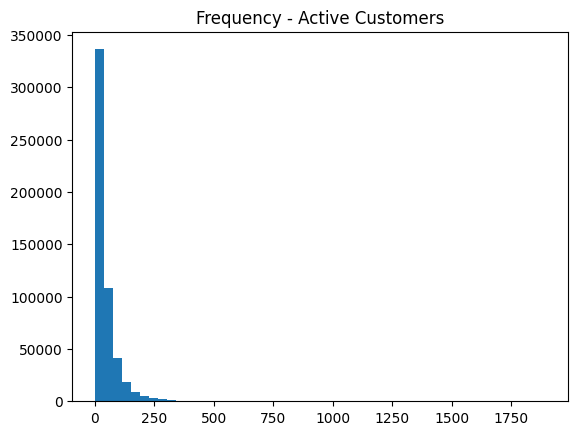

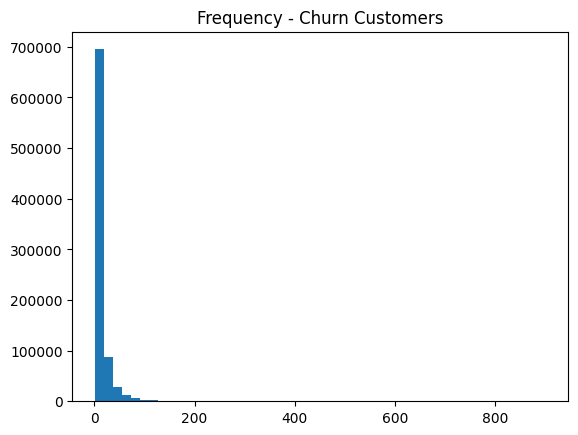

In [ ]:
 # 분포 확인 , 시각화

import matplotlib.pyplot as plt

plt.hist(rfm[rfm['churn']==0]['frequency'],bins=50)
plt.title("Frequency - Active Customers")
plt.show()

plt.hist(rfm[rfm['churn']==1]['frequency'], bins=50)
plt.title("Frequency - Churn Customers")
plt.show()

# **Feature Engineering**

In [ ]:
# Age Order Value 변수 추가 #

rfm['avg_order_value']=rfm['monetary']/rfm['frequency']
rfm.head()

,customer_id,latest_purchase,frequency,monetary,recency,churn,avg_order_value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,21,0.648983,17,0,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,86,2.601932,76,0,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,18,0.704780,7,0,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,2,0.060983,471,1,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,13,0.469695,41,0,0.036130


In [ ]:
# Customer Lifetime 계산 ( 고객 활동 기간 )

customer_lifetime = transactions.groupby('customer_id')['t_dat'].agg(['min','max']).reset_index()

customer_lifetime['lifetime_days'] = (
    customer_lifetime['max'] - customer_lifetime['min']
).dt.days

customer_lifetime = customer_lifetime[['customer_id','lifetime_days']]



In [ ]:
# rfm 에 merge
rfm=rfm.merge(customer_lifetime,on='customer_id',how='left')

In [ ]:
rfm.head()

,customer_id,latest_purchase,frequency,monetary,recency,churn,avg_order_value,lifetime_days
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,21,0.648983,17,0,0.030904,618
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,86,2.601932,76,0,0.030255,656
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,18,0.704780,7,0,0.039154,726
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,2,0.060983,471,1,0.030492,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,13,0.469695,41,0,0.036130,670


In [ ]:
rfm.describe()

,latest_purchase,frequency,monetary,recency,churn,avg_order_value,lifetime_days
count,1362281,1.362281e+06,1.362281e+06,1.362281e+06,1.362281e+06,1.362281e+06,1.362281e+06
mean,2020-01-30 20:26:15.037162240,2.333463e+01,6.493858e-01,2.351484e+02,6.145619e-01,2.875476e-02,2.733907e+02
min,2018-09-20 00:00:00,1.000000e+00,7.627119e-04,0.000000e+00,0.000000e+00,7.627119e-04,0.000000e+00
25%,2019-08-21 00:00:00,3.000000e+00,8.806780e-02,4.800000e+01,0.000000e+00,2.095763e-02,0.000000e+00
50%,2020-04-24 00:00:00,9.000000e+00,2.455932e-01,1.510000e+02,1.000000e+00,2.613317e-02,2.060000e+02
75%,2020-08-05 00:00:00,2.700000e+01,7.011864e-01,3.980000e+02,1.000000e+00,3.336083e-02,5.490000e+02
max,2020-09-22 00:00:00,1.895000e+03,5.767641e+01,7.330000e+02,1.000000e+00,5.067797e-01,7.330000e+02
std,NaN,3.924225e+01,1.197582e+00,2.211188e+02,4.866988e-01,1.429338e-02,2.699620e+02


어떤 행동 패턴이 이탈을 유발하는지 설명 가능하게!!


In [ ]:
rfm['lifetime_days'].mean()
rfm['lifetime_days'].describe()
rfm.isnull().sum()


,0
customer_id,0
latest_purchase,0
frequency,0
monetary,0
recency,0
churn,0
avg_order_value,0
lifetime_days,0


In [ ]:
rfm[['lifetime_days']].describe()


,lifetime_days
count,1.362281e+06
mean,2.733907e+02
std,2.699620e+02
min,0.000000e+00
25%,0.000000e+00
50%,2.060000e+02
75%,5.490000e+02
max,7.330000e+02


In [ ]:
rfm.to_csv("rfm_base_dataset.csv",index=False)